In [1]:
import damask
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

/home/snkrkr/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/snkrkr/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/snkrkr/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
resultfile_path = 'reference_output/tensionX_tensionY_material_fullfield_10grains_Al_10grains_voronoi_2x5x1/simulation_output.hdf5'

In [10]:
result = damask.Result(resultfile_path)
try:
    result.add_stress_Cauchy()
except ValueError:
    pass
try:
    result.add_equivalent_Mises('sigma')
except ValueError:
    pass
try:
    result.add_stress_second_Piola_Kirchhoff()
except ValueError:
    pass

try:
    result.add_strain()
except ValueError:
    pass

postprossecing_dir = Path(resultfile_path).stem
vti_path = list(Path(resultfile_path).parent.glob("*.vti"))[0]
grid = damask.GeomGrid.load(vti_path)
grid

cells:  2 × 5 × 1
size:   2e-05 × 5e-05 × 1e-05 m³
origin: 0.0   0.0   0.0 m
# materials: 10

# Example: Stress-strain curve for tensionX

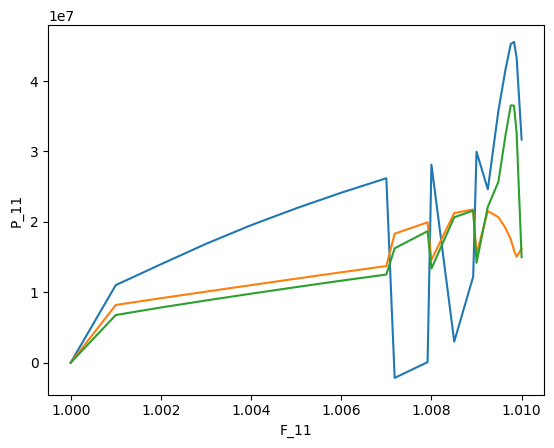

In [6]:
def plot_stress_strain_per_grain_fullfield(grains, grid, result):
    data = {g:pd.DataFrame() for g in grains}
    for inc in result.get(['F','P']).values():
        P = inc['P']
        F = inc['F']
        for g in grains:
            points = grid.material.flatten(order='F')==g
            P_11 = P[points,0,0].flatten()
            F_11 = np.broadcast_to(np.average(F[:,0,0]),P_11.shape)
            x = pd.DataFrame({'F_11':F_11,'P_11':P_11})
            data[g] = pd.concat((data[g],x),ignore_index=True)
    for g in grains:
      plot = sns.lineplot(y='P_11',x='F_11',data=data[g])
    fig = plot.get_figure()

plot_stress_strain_per_grain_fullfield([0, 1, 2], grid, result)


# Example: Stress-Strain Density plot for each grain 

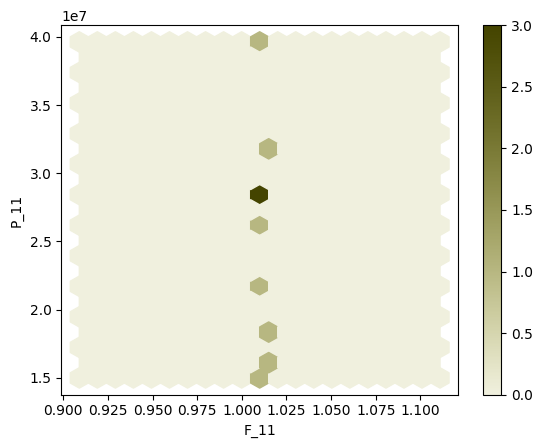

In [8]:
F_data = result.get('F')['increment_40']
P_data = result.get('P')['increment_40']

# slice the arrays to get F_11 and P_11
df = pd.DataFrame({
    'F_11': F_data[:, 0, 0],  # F(1,1)
    'P_11': P_data[:, 0, 0]   # P(1,1)
})

# Plotting density with hexbin
_ = df.plot.hexbin(x='F_11', y='P_11', gridsize=20, cmap=damask.Colormap.from_predefined('strain'))